<a href="https://colab.research.google.com/github/nithecs-biomath/mini-schools/blob/main/01_GEE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LECTURE 3: 16 October 2024
**Analysing Data Cubes**: Techniques and Tools for Ecological Modelling
In this lecture, participants will explore advanced analytical techniques and tools for ecological modelling using data cubes, with a focus on understanding climate-related impacts and adaptation strategies (SDG 13: Climate Action).

Let's walk through an example of how to use species occurrence data (e.g., from the Global Biodiversity Information Facility, GBIF) combined with climate data in Google Earth Engine (GEE) to understand climate-related impacts on species distributions. We'll also use Google Colab as our computational environment. This example will focus on visualizing the relationship between species occurrences and climate variables, and then assessing potential changes over time.


### Step-by-Step Guide:

1. **Setup in Google Colab**:
    - Install necessary libraries.
    - Authenticate and initialize Earth Engine.
    - Load and preprocess the GBIF data.
  
2. **Data Retrieval and Processing**:
    - Filter GBIF data for a specific species and region.
    - Retrieve climate data (e.g., temperature and precipitation) from Earth Engine.
    - Calculate summary statistics or indices relevant to climate action.

3. **Analysis and Visualization**:
    - Map species occurrences overlaid with climate data.
    - Analyze trends or shifts in species distributions over time.
    - Discuss potential adaptation strategies based on the observed patterns.

### Example Code:

Here's an example of how you could implement this in a Colab notebook. Make sure to run each cell sequentially.

#### 1. Setup in Google Colab

In [2]:
# Install Earth Engine API and authenticate
# !pip install earthengine-api
# !pip install geemap

# Import required libraries
import ee
import geemap
import pandas as pd
import folium
import matplotlib.pyplot as plt

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize(project='ee-biodatacube')


#### 2. Load and Preprocess GBIF Data

GBIF data can be loaded as a CSV, and here we'll assume you've already downloaded some data related to your species of interest.

In [12]:
# Load GBIF data into a pandas DataFrame
# Replace 'species_data.csv' with your GBIF data file path
# gbif_data = pd.read_csv('species_data.csv')


In [ ]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


In [17]:
# Step 2: Define the path to your CSV file in Google Drive
# Replace 'My Drive/path_to_your_file/Africa_abM_v4.csv' with your actual file path
# file_path = '/content/drive/My Drive/Colab Notebooks/Africa_abM_v4_subset.csv'
file_path = '/content/drive/My Drive/Colab Notebooks/africa_sum_v4.csv'

# Step 3: Read the CSV file into a pandas DataFrame
# Specify the encoding as 'latin-1'
gbif_data = pd.read_csv(file_path, encoding='latin-1')

# Display the first few rows of the DataFrame
gbif_data.head()

,Unnamed: 0,PlotID,DSnm,Ps,Coords_y,Coords_x,B,species,total_abundance
0,1,701_AMT-01_2004,Africa,0.025,-7.820240,36.969906,43.856600,Diospyros.zombensis,40.0
1,2,701_AMT-01_2004,Africa,0.025,-7.820240,36.969906,43.856600,Erythrophleum.suaveolens,80.0
2,3,701_AMT-01_2004,Africa,0.025,-7.820240,36.969906,43.856600,Lettowianthus.stellatus,160.0
3,4,701_AMT-02_2004,Africa,0.025,-7.825985,36.982039,58.532866,Anthocleista.grandiflora,40.0
4,5,701_AMT-02_2004,Africa,0.025,-7.825985,36.982039,58.532866,Erythrophleum.suaveolens,40.0


#### 3. Filter and Visualize GBIF Data on Map

In [18]:
# Convert GBIF data to Earth Engine FeatureCollection
def create_feature(row):
    return ee.Feature(ee.Geometry.Point([row['Coords_x'], row['Coords_y']]))

# Apply the function to create a list of features
features = gbif_data.apply(create_feature, axis=1).tolist()

# Create a FeatureCollection from the list of features
gbif_fc = ee.FeatureCollection(features)

# Initialize map
Map = geemap.Map(center=[0, 0], zoom=4)

# Add GBIF data to the map
Map.addLayer(gbif_fc, {'color': 'red'}, 'Species Occurrences')
Map


Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

#### 4. Retrieve Climate Data from Google Earth Engine


In [19]:
# Define time range and area of interest
start_date = '2000-01-01'
end_date = '2020-12-31'
region = ee.Geometry.Rectangle([-180, -90, 180, 90])

# Load climate data (e.g., monthly temperature from ERA5)
climate_data = ee.ImageCollection('ECMWF/ERA5/MONTHLY') \
    .select('mean_2m_air_temperature') \
    .filterDate(start_date, end_date) \
    .filterBounds(region)

# Calculate annual mean temperature
annual_mean_temp = climate_data.mean()

# Add climate data to the map
Map.addLayer(annual_mean_temp, {'min': 250, 'max': 310, 'palette': ['blue', 'green', 'red']}, 'Annual Mean Temperature')
Map


Map(bottom=4396.0, center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Searc…

#### 5. Analyze Species-Climate Relationship

In [20]:
# Overlay GBIF data with climate data to get climate values at each occurrence point
def extract_climate_info(feature):
    climate_value = annual_mean_temp.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=feature.geometry(),
        scale=1000
    )
    return feature.set(climate_value)


In [21]:
# Map the function over the GBIF FeatureCollection
climate_features = gbif_fc.map(extract_climate_info)


In [ ]:
# Convert to pandas DataFrame for analysis
climate_dict = climate_features.reduceColumns(ee.Reducer.toList(), ['mean_2m_air_temperature']).getInfo()
climate_df = pd.DataFrame(climate_dict)


In [22]:
# Display extracted climate data
climate_df.head()

,list
0,294.041351
1,294.041351
2,294.041351
3,294.041351
4,294.041351


#### 6. Visualizing and Interpreting Results

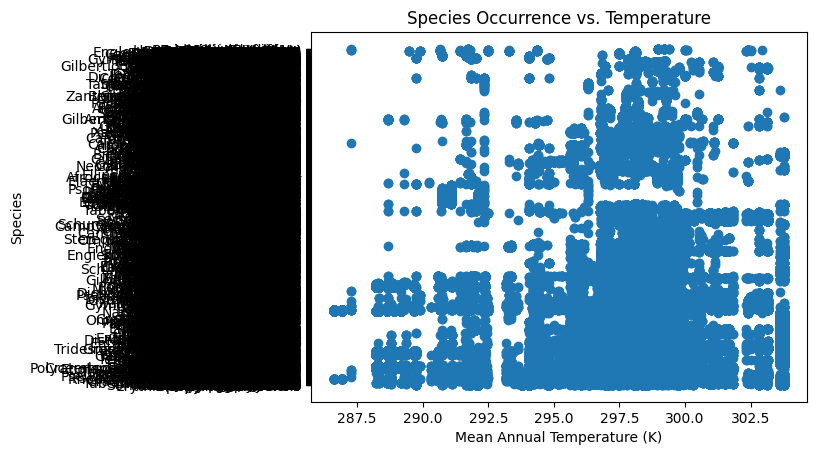

In [23]:
# Plot the relationship between species occurrence and temperature
# plt.scatter(climate_df['mean_2m_air_temperature'], gbif_data['species'])
plt.scatter(climate_df['list'], gbif_data['species'])
plt.xlabel('Mean Annual Temperature (K)')
plt.ylabel('Species')
plt.title('Species Occurrence vs. Temperature')
plt.show()


### Discussion

- **Observed Patterns**: The scatter plot illustrates the relationship between species occurrence and annual mean temperature.
- **Climate Impacts**: If the species occurrences show a strong correlation with specific temperature ranges, this could indicate climate sensitivity.
- **Adaptation Strategies**: For vulnerable species, strategies might include conservation in climate-resilient areas or assisted migration.